In [1]:
#%pip install --upgrade --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --user

In [2]:
from vizdoom import *
import gym
from gym import Env
from gym.spaces import Box, Discrete
import cv2
import random
import time
import numpy as np
import os
from matplotlib import pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy

In [4]:
game = DoomGame()
game.load_config('github/ViZDoom/scenarios/deadly_corridor_s1.cfg')
game.init()

In [5]:
for episode in range(1):
    game.new_episode()
    while not game.is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer
        info = state.game_variables
        reward = game.make_action(random.choice(np.identity(7, dtype=np.uint8)))
        print(f'reward: {reward}')
        time.sleep(0.02)
    print(f"Result: {game.get_total_reward()}")
game.close()

reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: -0.7779388427734375
reward: 0.072906494140625
reward: -0.002288818359375
reward: -0.7800140380859375
reward: -0.7068939208984375
reward: -0.640625
reward: -1.3614501953125
reward: -1.211395263671875
reward: -1.09783935546875
reward: -0.2136688232421875
reward: -0.1936492919921875
reward: -0.175506591796875
reward: -0.1590576171875
reward: -0.1441497802734375
reward: -0.911529541015625
reward: -0.8485107421875
reward: -0.7913970947265625
reward: -0.7396392822265625
reward: -1.4511871337890625
reward: -1.3151397705078125
reward: -0.4105987548828125
reward: -0.3721160888671875
reward: 0.4440155029296875
reward: -0.378875732421875
reward: -1.1246185302734375
reward: 0.0
reward: -0.124359130859375
reward: -0.112701416015625
reward: -0.125152587890625
reward: -0.0904388427734375
reward: -0.2292327880859375
reward: 0.0
reward: 0.0
reward: -0.0025634765625
reward: 0.0

In [3]:
class VizDoomGym(Env):
    def __init__(self, render=False, config='github/ViZDoom/scenarios/deadly_corridor_s1.cfg'):
        super().__init__()
        self.game = DoomGame()
        self.game.load_config(config)
        
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        self.game.init()
        
        self.observation_space = Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8)
        self.action_space = Discrete(7)
        
        self.damage_taken = 0
        self.hitcount = 0
        self.selected_weapon_ammo = 60
        
    def step(self, action):
        actions = np.identity(7, dtype=np.uint8)
        movement_reward = self.game.make_action(actions[action], 4)
        
        reward = 0
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            
            game_variables= self.game.get_state().game_variables
            health, damage_taken, hitcount, ammo = game_variables
            
            damage_taken_delta = -damage_taken + self.damage_taken
            self.damage_taken = damage_taken
            hitcount_delta = hitcount - self.hitcount
            self.hitcount = hitcount
            ammo_delta = ammo - self.selected_weapon_ammo
            self.selected_weapon_ammo = ammo
            
            reward = movement_reward + damage_taken_delta*10 + hitcount_delta*200 + ammo_delta
        
            info = ammo
        else:
            state = np.zeros(self.observation_space.shape)
            info = 0
        
        info = {'ammo': info}
        done = self.game.is_episode_finished()
        
        return state, reward, done, info
    
    def render():
        pass
    
    def reset(self):
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)
    
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,  100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100, 160, 1))
        return state
    
    def close(self):
        self.game.close()

In [4]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

In [5]:
env = VizDoomGym()

In [6]:
env_checker.check_env(env)

In [10]:
#env.close()

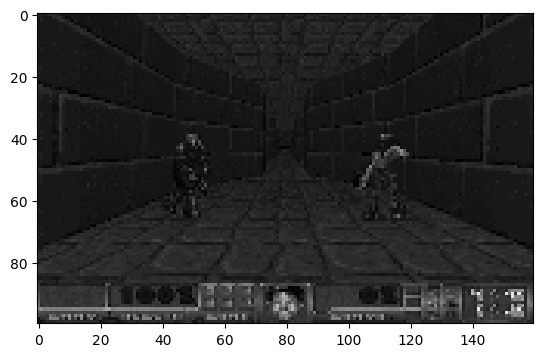

In [7]:
#plt.imshow(cv2.cvtColor(env.reset(), cv2.COLOR_BGR2RGB))

In [30]:
CHECKPOINT_DIR = './train/basic_train'
LOG_DIR = './logs/basic_log'

In [31]:
callback = TrainAndLoggingCallback(10000, CHECKPOINT_DIR)

In [36]:
model = PPO('CnnPolicy', env=env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.0001, n_steps=2048)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [38]:
model.learn(total_timesteps=1, callback=callback)

Logging to ./logs/basic_log\PPO_10
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 128      |
|    ep_rew_mean     | -90      |
| time/              |          |
|    fps             | 62       |
|    iterations      | 1        |
|    time_elapsed    | 32       |
|    total_timesteps | 2048     |
---------------------------------


In [43]:
#Probably the best model due to some strange training on the higher step models
model = PPO.load('train/basic_train/best_model_70000')

In [41]:
env = VizDoomGym(render=True)

In [46]:
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=20)

In [47]:
mean_reward

87.5

In [49]:
episodes = 10
for n in range(1, episodes+1):
    obs = env.reset()
    score = 0
    done = False
    while not done:
        action = model.predict(obs)
        obs, reward, done, info = env.step(action[0])
        score+=reward
        time.sleep(0.05)
    print(f'episode - {n} || score - {score}')

episode - 1 || score - 95.0
episode - 2 || score - 95.0
episode - 3 || score - 92.0
episode - 4 || score - 95.0
episode - 5 || score - 95.0
episode - 6 || score - -53.0
episode - 7 || score - 86.0
episode - 8 || score - 95.0
episode - 9 || score - 53.0
episode - 10 || score - 94.0


In [50]:
env.close()